
# The Growing Dispensary Industry in Phoenix
### Applied Data Science Capstone by IBM/Coursera



## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)




## Business Problem: <a name="introduction"></a>

With the growing acceptance and legalization of recreational marijuana, there is an increase demand for locations to purchase said goods. Arizona recently passed a law , opening the doors to recreational marijuna throughout the state. With this newly open market, there is oppurtunity to open up your own **dispensary**. But where is the best location? Are there already existing dispensaries? The goal of this capstone is to leverage the data available to find the best location to open up a new dispensary in the **Phoenix Metropolitan area of Arizona**. The target stakeholders would be interesting in opening a dispensary **franchise**. 
    
## Data: <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:

* Existing dispensaries in the area of interest
* Venues surrounding the dispensaries in the dataset
* Revenue data for the dispensaires in the dataset

We decided to focus in on the Phoenix Metroplitan area. To generate a list of locations to search for dispensaries, we can scrap a list of all the cities and their population size from **Wikipedia**. This data will be used to search for all the dispensaries in the greater Phoenix area, using the **FourSquare API**. The venue data for each dispensary can also be generated using the **FourSquare API**. Revenue data , unfortunately, is generally not publically accessible. To account for this, we will generate psuedo data to show the process that could be applied to a franchise purchase, where revenue data would be readily available

### Import Necessary Libraries

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas import json_normalize
import numpy as np
import folium
import seaborn as sns

In [9]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#
# ML Libraries
#
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#
# Import geopy locator to find lat/lons of address
#
from geopy.geocoders import Nominatim

from IPython.display import Markdown as md

## Generating Search Location Data

### Scraping Wikipedia for List of Phoenix Cities and their Population Size

Let's parse city and population data from a wikipedia page defining the Phoenix Metropolitan area.

We can then narrow down the cities we search in by population size to keep our api searches reasonable and
focused on large customer base potential.

In [10]:
#
# pulling html from wikipedia to parse with BeautifulSoup
#
source = requests.get('https://en.wikipedia.org/wiki/Phoenix_metropolitan_area').text
soup = BeautifulSoup(source, 'html.parser')

#print(soup.prettify())

In [11]:
#
# Parsing hmtl and storing results in data frame
#
df_city_pop = pd.DataFrame(columns=['location.city','Population'])    


city        = None

for group in soup.find_all('ul'):
    for bullet in group.find_all('li'):
        
        #
        #if bullet.find_all(title=True) is not None:
        #
        
        if "pop." in bullet.text:
            [city,pop] = bullet.text.split('pop.')
            pop = int(pop.replace(',',''))
            city = city.strip()
            
            #
            # Only Looking at City's with a population greater than 60k to
            # refine scope to largely populated areas
            #
            
            if pop > 30000:
                df_city_pop = df_city_pop.append({'location.city':city,'Population':pop},ignore_index=True)
                
            #
            # Printing out the city name
            #
          
        print(city)
    #
    # Stopping at Mammoth city because this is the last incorporated community in the wikipedia list
    #             
    if city is not None and "Mammoth" in [city]:
        break
            

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Phoenix
Mesa
Chandler
Scottsdale
Glendale
Gilbert
Tempe
Peoria
Surprise
Avondale
Goodyear
Buckeye
Casa Grande
Maricopa
Apache Junction
Queen Creek
El Mirage
Florence
Fountain Hills
Eloy
Paradise Valley
Coolidge
Wickenburg
Tolleson
Youngtown
Guadalupe
Litchfield Park
Cave Creek
Carefree
Superior
Kearny
Gila Bend
Mammoth


In [12]:
df_city_pop

,location.city,Population
0,Phoenix,1626078
1,Mesa,496401
2,Chandler,253458
3,Scottsdale,249950
4,Glendale,246709
5,Gilbert,242354
6,Tempe,185038
7,Peoria,168181
8,Surprise,134085
9,Avondale,84025


In [13]:
df_city_pop.shape

(17, 2)

### Foursquare 
Setting up the foursquare api credentials

In [14]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)
###################################################################################################
CLIENT_ID     = 'WBRF42132RGOALCABMLFUCHCBTTQBPBYF1LVOTTSMU45KRFT' # your Foursquare ID
CLIENT_SECRET = 'H0N4D1U05DPGI54W2VO4FYF3COLQFMKXVSWUVEG2YMT4RPOE' # your Foursquare Secret
VERSION       = '20180604'
LIMIT         = 30
print('Your credentails have been loaded')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails have been loaded


### Dispensary Data
Using the FourSquare API, we can search for all the dispenaries in our cities defined previously.

To loop through each city, we can write a function that will edit the api search url.

In [15]:
state = 'AZ'
search_query = 'Dispensary'

In [16]:
def getDispensaryLocation(city,state):
    
    venues_list=[]
    for city_name in city:
        print(city_name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={},{}&v={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            city_name,
            state, 
            VERSION, 
            search_query,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()

        # return only relevant information for each nearby venue
        venues = results['response']['venues']

        # tranform venues into a dataframe
        dataframe = json_normalize(venues)
        
        #append dataframe to venues_list
        venues_list.append(dataframe)

    dispensaries = pd.concat(venues_list)
    
    return(dispensaries)

In [23]:
"""
Preventing rerunning api when rerunning script. Once run, we save the dataframe to a csv to be loaded later

dispensaries = getDispensaryLocation(city=df_city_pop['location.city'],state='AZ')
dispensaries = dispensaries.merge(df_city_pop,how='left',on='location.city')
dispensaries.head()
dispensaries.shape
"""

dispensaries = pd.read_csv('dispensaries.csv')
dispensaries.head()

,Unnamed: 0,Unnamed: 0.1,id,Store,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,Population
0,0,0,51899feb498eeae46a8efe15,Bloom Dispensary,"[{'id': '52c71aaf3cf9994f4e043d17', 'name': 'M...",v-1615097078,False,14 S 41st Pl,at Washington,33.447500,-111.991792,"[{'label': 'display', 'lat': 33.44749951230231...",85034.0,US,Phoenix,AZ,United States,"['14 S 41st Pl (at Washington)', 'Phoenix, AZ ...",NaN,1626078.0
1,1,1,52599d4d498e80ed54bad45a,TruMed Dispensary,"[{'id': '52e81612bcbc57f1066b7a3c', 'name': 'A...",v-1615097078,False,1613 North 40th Street,NaN,33.466282,-111.995232,"[{'label': 'display', 'lat': 33.46628185, 'lng...",85008.0,US,Phoenix,AZ,United States,"['1613 North 40th Street', 'Phoenix, AZ 85008'...",435690147.0,1626078.0
2,2,2,5ed2cc9095fee90009aacdcb,Sunnyside Medical Cannabis Dispensary - Phoenix,"[{'id': '52c71aaf3cf9994f4e043d17', 'name': 'M...",v-1615097078,False,2620 W Encanto Blvd,NaN,33.473428,-112.116735,"[{'label': 'display', 'lat': 33.473428, 'lng':...",85009.0,US,Phoenix,AZ,United States,"['2620 W Encanto Blvd', 'Phoenix, AZ 85009', '...",NaN,1626078.0
3,3,3,531b7f33498e1bd4f343310c,"Phoenix Relief Center, Medical Marijuana Dispe...","[{'id': '52c71aaf3cf9994f4e043d17', 'name': 'M...",v-1615097078,False,6330 S 35th Ave #104,NaN,33.389118,-112.134346,"[{'label': 'display', 'lat': 33.38911819458008...",85041.0,US,Phoenix,AZ,United States,"['6330 S 35th Ave #104', 'Phoenix, AZ 85041', ...",100451509.0,1626078.0
4,4,4,5a9443ca1953f34302e4bb16,MüV Dispensary,"[{'id': '52e81612bcbc57f1066b7a3c', 'name': 'A...",v-1615097078,False,12620 North Cave Creek Road Suite #1,NaN,33.601669,-112.037756,"[{'label': 'display', 'lat': 33.601669, 'lng':...",85022.0,US,Phoenix,AZ,United States,"['12620 North Cave Creek Road Suite #1', 'Phoe...",483678208.0,1626078.0


### Visualizing Dispensaries using Folium 

Plotting the dispensaries allows to get a visual to see if there should be a clustering of the 
dispensaries before characterizing the dispensaries near by venues. If there are a group of dispensaries too close together, it could

In [20]:
longitude  = -112.074
latitude = 33.2
map_phoenix_metro = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, store in zip(dispensaries['location.lat'], dispensaries['location.lng'], dispensaries['Store']):
    label = '{}'.format(store)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phoenix_metro)  
    
map_phoenix_metro

### Venue Data

Now we can use teh same FourSquare API to collect Nearby Venue data for each dispensary. 

A function can be written to loop through each dispensary.

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Store', 
                  'Store Latitude', 
                  'Store Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
"""
Prevent running the api in future runs by saving to a csv and loading on later reruns
dispensary_venues = getNearbyVenues(names=dispensaries['name'],
                                   latitudes=dispensaries['location.lat'],
                                   longitudes=dispensaries['location.lng']
                                  )
"""
dispensary_venues = pd.read_csv('dispensary_venues.csv')

In [26]:
dispensary_venues.head()

,Unnamed: 0,Unnamed: 0.1,Store,Store Latitude,Store Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,0,Bloom Dispensary,33.4475,-111.991792,Bloom Dispensary,33.447500,-111.991792,Marijuana Dispensary
1,1,1,Bloom Dispensary,33.4475,-111.991792,PHX Skytrain Station,33.446822,-111.990316,Light Rail Station
2,2,2,Bloom Dispensary,33.4475,-111.991792,Speedy Street Tacos,33.448568,-111.995166,Taco Place
3,3,3,Bloom Dispensary,33.4475,-111.991792,Crowne Plaza Phoenix Airport,33.448858,-111.988521,Hotel
4,4,4,Bloom Dispensary,33.4475,-111.991792,Papa John's Pizza,33.449169,-111.995499,Pizza Place


We now have all the dispensaries in the Phoenix Metropolitan Area **AND** the surrounding venues to each respective dispensary.

This is the end of the data collection section. We can now move to the data analysis.

## METHODOLOGY <a name="methodology"></a>



In this study, we want to be able to identify the best location , given a set of several locations, to open a new dispensary. 

To be able to distinguish the best location , we need to be able to relate them to the existing data set. This is going to be accomplished by first generating groups (using ***k-means clustering***), which will allow us to label the dispensary data set. 

The Cluster groups can then be used to generate a model to ***classify*** our potential locations using a ***K-Nearest Neighbors*** model. 

Combining the Cluster Group and average revenue of each group will be a great start for generating a recommendation for the stakeholders.

### Analysis

The first step to analyzing the data is to get a general overview of the ***number of venues*** surrounding each store.

In [30]:
#
# Check how many venues where returned for each store
#
dispensary_venues.groupby('Store').count()['Venue']

Store
All Greens Dispensary                                                  162
Arizona Cannabis Dispensary                                             78
Arizona Natural Concepts Medical Marijuana Dispensary                   21
Arizona Natural Selections of Mesa Dispensary                          120
Arizona Natural Selections of Peoria Dispensary                        132
Bloom Dispensary                                                       298
Curaleaf Dispensary Pavilions                                           28
Desert Rose Dispensary                                                   6
Emerald Dispensary                                                     175
Emerald Dispensary Phoenix                                             175
Encanto Green Cross                                                      8
GREENPHARMS Dispensary                                                  48
Giving Tree Dispensary                                                  11
Glendale CBD Dispen

In [28]:
print('There are {} uniques categories.'.format(len(dispensary_venues['Venue Category'].unique())))

There are 174 uniques categories.


In [20]:
# one hot encoding
dispensary_onehot = pd.get_dummies(dispensary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dispensary_onehot['Store'] = dispensary_venues['Store'] 

# move neighborhood column to the first column
fixed_columns = [dispensary_onehot.columns[-1]] + list(dispensary_onehot.columns[:-1])
dispensary_onehot = dispensary_onehot[fixed_columns]

dispensary_onehot.head()

,Store,ATM,Adult Education Center,Airport,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,...,Train Station,Vehicle Inspection Station,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,TruMed Dispensary,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TruMed Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TruMed Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,TruMed Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TruMed Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
dispensary_grouped = dispensary_onehot.groupby('Store').mean().reset_index()
dispensary_grouped.head()

,Store,ATM,Adult Education Center,Airport,Airport Terminal,Alternative Healer,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,...,Train Station,Vehicle Inspection Station,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,All Greens Dispensary,0.043478,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.043478,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,Arizona Cannabis Dispensary,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,Arizona Natural Concepts Medical Marijuana Dis...,0.000000,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,Arizona Natural Selections of Mesa Dispensary,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.047619,0.000000
4,Arizona Natural Selections of Peoria Dispensary,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.047619,0.0,0.0,0.000000,0.000000,0.047619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Top Shelf Dispensary,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
57,TruMed Dispensary,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.090909,0.0,0.0,0.000000,0.000000,0.000000
58,Urban Greenhouse Dispensary,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.178218,0.000000,0.000000
59,Valley Of The Sun Medical Dispensary,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.269231,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


#### Let's print each neighborhood along with the top 5 most common venues

In [22]:
num_top_venues = 5

for hood in dispensary_grouped['Store']:
    print("----"+hood+"----")
    temp = dispensary_grouped[dispensary_grouped['Store'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----All Greens Dispensary----
                  venue  freq
0                  Bank  0.09
1  Fast Food Restaurant  0.09
2                   ATM  0.04
3  Cantonese Restaurant  0.04
4           Coffee Shop  0.04


----Arizona Cannabis Dispensary----
            venue  freq
0  Baseball Field  0.18
1      Taco Place  0.18
2  Shop & Service  0.09
3     Pizza Place  0.09
4            Park  0.09


----Arizona Natural Concepts Medical Marijuana Dispensary----
                 venue  freq
0          Pizza Place  0.17
1             Pharmacy  0.17
2  American Restaurant  0.17
3            Pet Store  0.17
4          Coffee Shop  0.17


----Arizona Natural Selections of Mesa Dispensary----
                  venue  freq
0     Mobile Phone Shop  0.14
1  Fast Food Restaurant  0.10
2     Convenience Store  0.05
3            Food Truck  0.05
4   Sporting Goods Shop  0.05


----Arizona Natural Selections of Peoria Dispensary----
                    venue  freq
0    Fast Food Restaurant  0.14
1           

                 venue  freq
0                Hotel  0.12
1    Convenience Store  0.08
2            BBQ Joint  0.06
3  American Restaurant  0.06
4      Automotive Shop  0.06


----Territory Dispensary Mesa----
                  venue  freq
0  Fast Food Restaurant  0.43
1          Intersection  0.14
2           Gas Station  0.14
3     Convenience Store  0.14
4          Liquor Store  0.14


----The Arizona Dispensary----
            venue  freq
0            Pool  0.07
1       Pet Store  0.07
2         Brewery  0.07
3  Breakfast Spot  0.07
4             Gym  0.07


----The Good Dispensary----
                   venue  freq
0      Convenience Store  0.15
1  Vietnamese Restaurant  0.10
2      Korean Restaurant  0.05
3            Supermarket  0.05
4         Discount Store  0.05


----The Green House Dispensary----
                  venue  freq
0  Fast Food Restaurant  0.17
1           Pizza Place  0.08
2            Donut Shop  0.04
3         Auto Workshop  0.04
4   Fried Chicken Joint  0.04


#### Let's put that into a _pandas_ dataframe
First, let's write a function to sort the venues in descending order.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [24]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Store']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
dispensary_venues_sorted = pd.DataFrame(columns=columns)
dispensary_venues_sorted['Store'] = dispensary_grouped['Store']

for ind in np.arange(dispensary_grouped.shape[0]):
    dispensary_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dispensary_grouped.iloc[ind, :], num_top_venues)

dispensary_venues_sorted.head()


,Store,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,All Greens Dispensary,Bank,Fast Food Restaurant,ATM,Cantonese Restaurant,Coffee Shop
1,Arizona Cannabis Dispensary,Baseball Field,Taco Place,Shop & Service,Pizza Place,Park
2,Arizona Natural Concepts Medical Marijuana Dis...,Pizza Place,Pharmacy,American Restaurant,Pet Store,Coffee Shop
3,Arizona Natural Selections of Mesa Dispensary,Mobile Phone Shop,Fast Food Restaurant,Convenience Store,Food Truck,Sporting Goods Shop
4,Arizona Natural Selections of Peoria Dispensary,Fast Food Restaurant,Intersection,Convenience Store,Furniture / Home Store,Mexican Restaurant


In [25]:
dispensaries = pd.read_csv('dispensaries.csv')
dispensaries = dispensaries.rename(columns={'name':'Store'})
dispensaries = dispensaries.drop_duplicates(subset=['location.address'])

In [26]:
dispensary_venues = pd.read_csv('dispensary_venues.csv')

## Clustering

Now that we have collected the venues nearby our dispensaries, 
let's ordered the data by frequency and generate a one-hot 
dataframe for clustering.


In [60]:
#
# Dropping the Venue if the Venue Matches the Store name
#
dispensary_venues = dispensary_venues[dispensary_venues['Store'] != dispensary_venues['Venue']]
#
# Check how many venues where returned for each store
#
dispensary_venues.groupby('Store').count()

,Unnamed: 0,Store Latitude,Store Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Store,,,,,,,
All Greens Dispensary,162,162,162,162,162,162,162
Arizona Cannabis Dispensary,78,78,78,78,78,78,78
Arizona Natural Concepts Medical Marijuana Dispensary,21,21,21,21,21,21,21
Arizona Natural Selections of Mesa Dispensary,120,120,120,120,120,120,120
Arizona Natural Selections of Peoria Dispensary,126,126,126,126,126,126,126
Bloom Dispensary,287,287,287,287,287,287,287
Curaleaf Dispensary Pavilions,28,28,28,28,28,28,28
Desert Rose Dispensary,6,6,6,6,6,6,6
Emerald Dispensary,175,175,175,175,175,175,175


In [61]:
print('There are {} uniques categories.'.format(len(dispensary_venues['Venue Category'].unique())))

There are 172 uniques categories.


In [62]:
# one hot encoding
dispensary_onehot = pd.get_dummies(dispensary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dispensary_onehot['Store'] = dispensary_venues['Store'] 

# move neighborhood column to the first column
fixed_columns = [dispensary_onehot.columns[-1]] + list(dispensary_onehot.columns[:-1])
dispensary_onehot = dispensary_onehot[fixed_columns]

dispensary_onehot.head()

,Store,ATM,Adult Education Center,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,...,Tourist Information Center,Toy / Game Store,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
1,Bloom Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bloom Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bloom Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bloom Dispensary,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Bloom Dispensary,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by store and take the mean of the frequency of occurrence of each category

In [63]:
dispensary_grouped = dispensary_onehot.groupby('Store').mean().reset_index()
dispensary_grouped

,Store,ATM,Adult Education Center,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,...,Tourist Information Center,Toy / Game Store,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,All Greens Dispensary,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arizona Cannabis Dispensary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arizona Natural Concepts Medical Marijuana Dis...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Arizona Natural Selections of Mesa Dispensary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000
4,Arizona Natural Selections of Peoria Dispensary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.047619
5,Bloom Dispensary,0.000000,0.000000,0.038328,0.000000,0.038328,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.020906,0.000000,0.000000,0.000000,0.000000,0.000000
6,Curaleaf Dispensary Pavilions,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
7,Desert Rose Dispensary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Emerald Dispensary,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000
9,Emerald Dispensary Phoenix,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000


#### Let's print each store along with the top 10 most common venues

In [64]:
num_top_venues = 10

for store in dispensary_grouped['Store']:
    print("----"+store+"----")
    temp = dispensary_grouped[dispensary_grouped['Store'] == store].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----All Greens Dispensary----
                  venue  freq
0  Fast Food Restaurant  0.07
1                  Bank  0.07
2          Burger Joint  0.04
3           Coffee Shop  0.04
4     Convenience Store  0.04
5        Cosmetics Shop  0.04
6        Shipping Store  0.04
7        Discount Store  0.04
8   Rental Car Location  0.04
9     Recreation Center  0.04


----Arizona Cannabis Dispensary----
                venue  freq
0          Taco Place  0.15
1      Baseball Field  0.15
2   Electronics Store  0.08
3         Escape Room  0.08
4      Cosmetics Shop  0.08
5   Convenience Store  0.08
6         Pizza Place  0.08
7    Greek Restaurant  0.08
8      Shop & Service  0.08
9  Mexican Restaurant  0.08


----Arizona Natural Concepts Medical Marijuana Dispensary----
                 venue  freq
0          Coffee Shop  0.29
1  American Restaurant  0.14
2          Pizza Place  0.14
3             Pharmacy  0.14
4            Pet Store  0.14
5   Mexican Restaurant  0.14
6                  ATM  0.0

9                     Pub  0.08


----Medical Marijuana Dispensary----
                venue  freq
0          Restaurant  0.06
1      Massage Studio  0.06
2          Steakhouse  0.06
3           Nightclub  0.06
4         Bridal Shop  0.06
5        Chiropractor  0.06
6      Breakfast Spot  0.06
7       Grocery Store  0.06
8  Frozen Yogurt Shop  0.06
9            Tea Room  0.06


----Mesa Dispensary - Medical Marijuana | Tru- Bliss AZ - Phoenix----
                           venue  freq
0                 Farmers Market   0.4
1                           Farm   0.2
2              Convenience Store   0.2
3                           Café   0.2
4        New American Restaurant   0.0
5                      Nightclub   0.0
6                 Nightlife Spot   0.0
7                   Optical Shop   0.0
8              Other Repair Shop   0.0
9  Paper / Office Supplies Store   0.0


----Metro Meds Dispensary----
                  venue  freq
0  Fast Food Restaurant  0.10
1    Mexican Restaurant  0.0

             venue  freq
0   Clothing Store  0.07
1  Supplement Shop  0.07
2     Burger Joint  0.03
3   Shipping Store  0.03
4      Bridal Shop  0.03
5  Bubble Tea Shop  0.03
6              Spa  0.03
7   Shopping Plaza  0.03
8   Cosmetics Shop  0.03
9       Shoe Store  0.03


----The Semen Dispensary----
                     venue  freq
0                     Park  0.25
1                     Pool  0.25
2               Playground  0.25
3         Business Service  0.25
4        Other Repair Shop  0.00
5              Music Venue  0.00
6               Nail Salon  0.00
7  New American Restaurant  0.00
8                Nightclub  0.00
9           Nightlife Spot  0.00


----Top Shelf Dispensary----
                     venue  freq
0      Rental Car Location  0.25
1             Intersection  0.25
2           Soccer Stadium  0.25
3             Home Service  0.25
4                      ATM  0.00
5        Other Repair Shop  0.00
6              Music Store  0.00
7              Music Venue  0.00
8  

#### First, let's write a function to sort the venues in descending order.

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create the new dataframe and display the top 10 venues for each store.

In [66]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Store']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
dispensary_venues_sorted = pd.DataFrame(columns=columns)
dispensary_venues_sorted['Store'] = dispensary_grouped['Store']

for ind in np.arange(dispensary_grouped.shape[0]):
    dispensary_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dispensary_grouped.iloc[ind, :], num_top_venues)

dispensary_venues_sorted.head()

,Store,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,All Greens Dispensary,Fast Food Restaurant,Bank,Burger Joint,Coffee Shop,Convenience Store,Cosmetics Shop,Shipping Store,Discount Store,Rental Car Location,Recreation Center
1,Arizona Cannabis Dispensary,Taco Place,Baseball Field,Electronics Store,Escape Room,Cosmetics Shop,Convenience Store,Pizza Place,Greek Restaurant,Shop & Service,Mexican Restaurant
2,Arizona Natural Concepts Medical Marijuana Dis...,Coffee Shop,American Restaurant,Pizza Place,Pharmacy,Pet Store,Mexican Restaurant,ATM,Other Repair Shop,Music Venue,Nail Salon
3,Arizona Natural Selections of Mesa Dispensary,Mobile Phone Shop,Mexican Restaurant,Fast Food Restaurant,Sporting Goods Shop,Burger Joint,Food Truck,Music Store,Shipping Store,Bank,Convenience Store
4,Arizona Natural Selections of Peoria Dispensary,Fast Food Restaurant,Furniture / Home Store,Mexican Restaurant,Convenience Store,Intersection,Costume Shop,Hardware Store,Salon / Barbershop,Pharmacy,Women's Store


## ***Clustering the Stores by Nearby Venues***

Run K-Means to cluster the stores by the surrounding venues.



In [67]:
# set number of clusters
kclusters = 7

dispensary_grouped_clustering = dispensary_grouped.drop('Store', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dispensary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 0, 1, 0, 5, 4, 4], dtype=int32)

### Creating a dataframe of the dispensaries with their cluster label and top ten venues

In [68]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
dispensary_venues_sorted['Cluster Labels'] = kmeans.labels_
dispensary_merged = dispensaries

# merge dispensary grouped with dispensary_data to add latitude/longitude for each neighborhood
dispensary_merged = dispensary_merged.join(dispensary_venues_sorted.set_index('Store'), on='Store')

dispensary_merged.head() # check the last columns!

dispensary_merged.dropna(inplace=True,subset=['Cluster Labels'])

### Visualizing the Clusters on a map

In [69]:
longitude  = -112.074
latitude = 33.2
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dispensary_merged['location.lat'], dispensary_merged['location.lng'], dispensary_merged['Store'], dispensary_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters) 
    
map_clusters

In [70]:
"""
To visualize the top venues in each cluster, we can plot a 
the frequency of  the top ten venue categories, in a histogram.
"""
#
# Pull the columns with the top ten Venues for each dispensary
#

common_venue_cols = [col for col in dispensary_merged.columns if 'Common' in col]
common_venue_cols

['1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [71]:
"""
Function to plot top ten venues in each cluster in a histogram
"""
def plot_cluster(cluster,title):
    cluster = cluster.filter(common_venue_cols)
    cluster = pd.concat(cluster[col] for col in cluster)
    cluster.name = "Venues"
    cluster = cluster.to_frame()

    #
    # Plotting data
    #
    sns.set()
    fig, ax = plt.subplots()
    fig.set_size_inches=(7,5)
    sns.countplot(x ="Venues",data = cluster,order=cluster['Venues'].value_counts().iloc[:10].index,color=sns.color_palette()[0],ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
    ax.set_title(title)

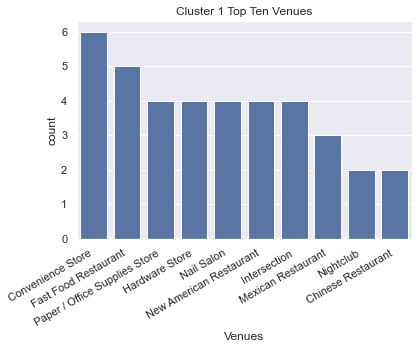

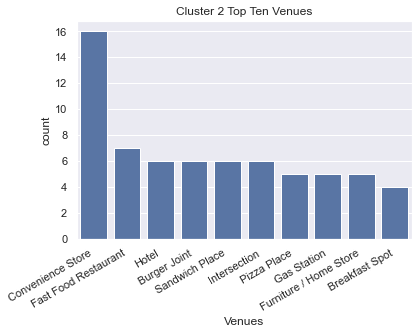

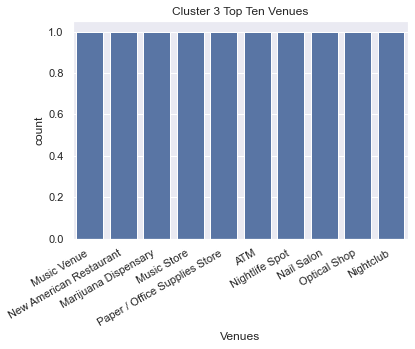

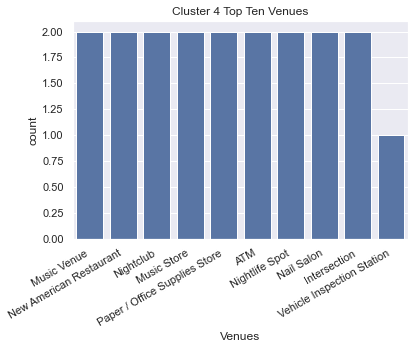

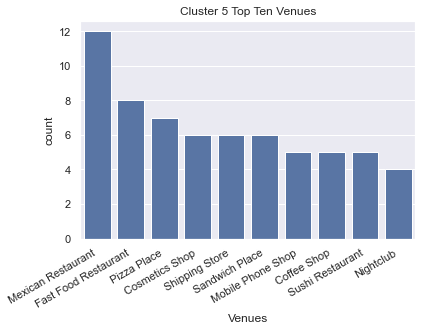

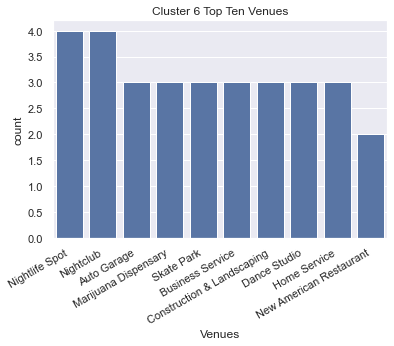

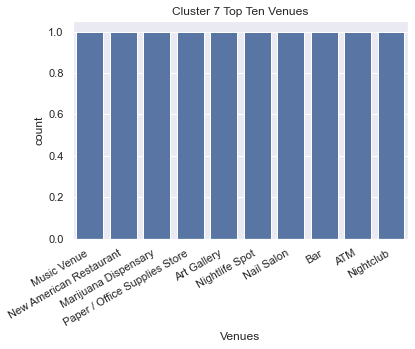

In [72]:
#
# Plotting each cluster's top ten venues frequency histogram
#
cluster_groups = dispensary_merged.groupby("Cluster Labels")
for key,group in cluster_groups:
    plot_cluster(group,"Cluster {} Top Ten Venues".format(int(key+1)))

# Creating K-Nearest model to classify potential locations

In [73]:
#
# Normalizing the data to prevent skewing by a dominant
# feature.
#

X = dispensary_grouped_clustering.values  #.astype(float)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
y = kmeans.labels_

In [41]:
#
# Splitting the given data to train and test t
#

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (44, 174) (44,)
Test set: (12, 174) (12,)


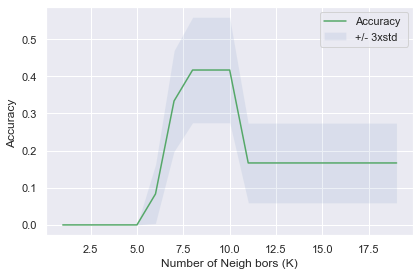

The best accuracy was 0.4166666666666667 with k= 8


In [42]:
#
# Looping through possible k values in kmeans algorithm
# to assess which value k value with give the best accuracy
# for our dataset. 
#

Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc
std_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neigh bors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


In [84]:
md("The best accuracy accured when k was set to {}. Thus \
we will set k to six for the classification of potential\
dispensary locations.\
The accuracy, however, is quite low at {}% accuracy. This is most likely\
due to small dataset. This can improve by increasing the number of cities we are looking at.\
The more dispensaries we look at, the more training data we can have and increase the \
accuracy of our model. I have chose to limit the dataset for this project to prevent charges by the\
Foursquare API, but in a business case we would want to pull as many dispensary datasets within \
reason. \
".format(mean_acc.argmax()+1,np.round(mean_acc.max(),2)))

The best accuracy accured when k was set to 8. Thus we will set k to six for the classification of potentialdispensary locations.The accuracy, however, is quite low at 0.42% accuracy. This is most likelydue to small dataset. This can improve by increasing the number of cities we are looking at.The more dispensaries we look at, the more training data we can have and increase the accuracy of our model. I have chose to limit the dataset for this project to prevent charges by theFoursquare API, but in a business case we would want to pull as many dispensary datasets within reason. 

In [85]:
k = mean_acc.argmax()+1
# generate model 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh


"""
Now that we have our model to classifiy our potential locations, we can define our the
locations we are interesting in. Classifying our locations will provide critical information 
in deciding which potential venue is best, along with other data like cost. 

I would like to note the "desired" cluster in our case is chosen to be the largest cluster group, however, 
a better approach would be too measure the clusters by some metric. Ideally, this metric would be the average 
revenue of each cluster, but unfortunately that data is not available. I will generate psuedo-data to illustrate 
how this data can be used to rank the clusters. This method would be particularly useful when the data is made available 
to the business owner like franchise businesses. 
"""

revenue = np.random.rand(labeled_cluster_group.shape[0],1)*1000000
clust_revenue = pd.DataFrame(np.column_stack((revenue,kmeans.labels_)),columns=['Revenue','Cluster'])
clust_revenue.head()

#
# Find Average revenue of each cluster and append
# the size of each cluster 
#

clust_rev_stats = clust_revenue.groupby(['Cluster']).mean()
clust_rev_stats['Size'] = clust_revenue['Cluster'].value_counts()

"""
For our example, we know the nearest neighbors model is going to be most accurate in 
classifying the cluster with the largest size because the cluster sizes are heavy focused
in a single cluster. Because this is random sample revenue data, we will force the largest
cluster to have the highest revenue. 
"""

max_indx = clust_rev_stats.idxmax(axis=0)
clust_rev_stats['Revenue'].iloc[int(max_indx['Size'])] = clust_rev_stats['Revenue'].iloc[int(max_indx['Revenue'])] + 5000

"""
Now we need to Locations of Interest. This would be a customer input. They would give you a 
list of locations and then the nearby venues of those locations could be pulled to classify 
each location into a given cluster and reccomend the location based on the cluster data.

The below locations where found looking for retial locations in Arizona that are open for lease 
in three different locations.
"""

"""
https://www.loopnet.com/Listing/14175-W-Indian-School-Rd-Goodyear-AZ/12567188/
"""
location_one   = '14175 W Indian School Rd, Goodyear, AZ'
"""
https://www.loopnet.com/Listing/4874-S-Val-Vista-Dr-Gilbert-AZ/12086014/
"""
location_two   = '4874 S Val Vista Dr, Gilbert, AZ'
"""
https://www.loopnet.com/Listing/N-99th-Ave-Avondale-AZ/15410814/
"""
location_three = 'N 99TH AVE , AVONDALE, AZ 85323'


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 56 and the array at index 1 has size 55

## Find the nearby venues of the potential locations

In [51]:
locator         = Nominatim(user_agent='MyGeocoder')
location_one_   = locator.geocode(location_one)
location_two_   = locator.geocode(location_two)
location_three_ = locator.geocode(location_three)
# %%

#
# Put the location data into a dataframe
#

df_locations = pd.DataFrame()

location_names      = ['Litchfield','Chandler','Avondale']
location_latitudes  = [location_one_.latitude,location_two_.latitude,location_three_.latitude]
location_longitudes = [location_one_.longitude,location_two_.longitude,location_three_.longitude]

df_locations['Locations']  = location_names
df_locations['Latitudes']  = location_latitudes
df_locations['Longitudes'] = location_longitudes

In [86]:
#
# Get the nearby venues of each location
#

#location_venues = getNearbyVenues(names = df_locations['Locations'],
#                                  latitudes = df_locations['Latitudes'],
#                                  longitudes = df_locations['Longitudes'])

location_venues = pd.read_csv('LocationVenues.csv')

In [53]:
location_venues.groupby('Store').count()

# one hot encoding
location_onehot = pd.get_dummies(location_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
location_onehot['Store'] = location_venues['Store'] 

# move neighborhood column to the first column
fixed_columns   = [location_onehot.columns[-1]] + list(location_onehot.columns[:-1])
location_onehot = location_onehot[fixed_columns]

location_onehot.head()

location_grouped = location_onehot.groupby('Store').mean().reset_index()


#
# Adding missing columns to the location matrix
#
loc_cols               = np.array(location_grouped.columns)
dis_cols               = np.array(dispensary_grouped.columns)
diff                   = [col for col in dis_cols if col not in loc_cols]
location_grouped[diff] = 0.0

#
# Removing columns in location matrix that are not apart of the original dataset
#

diff_remove      = [col for col in loc_cols if col not in dis_cols]
location_grouped = location_grouped.drop(diff_remove,1)

In [54]:
#
# Sort Columns to alphabetic order, to match dispensary venue dataframe
#
location_grouped = location_grouped.reindex(sorted(location_grouped.columns),axis=1)
location_grouped.head()

#
# Drop the stores column
#

location_grouped = location_grouped.drop('Store',1)

In [55]:
#
# Process venue data 
#

X_loc = location_grouped.values  #.astype(float)
X_loc = preprocessing.StandardScaler().fit(X_loc).transform(X_loc.astype(float))

clust_results = neigh.predict(X_loc)
clust_results

array([0, 1, 5], dtype=int32)

In [56]:
clust_rev_stats

,Revenue,Size
Cluster,,
0.0,525889.880445,7
1.0,726190.308403,2
2.0,536307.568756,2
3.0,755739.807131,36
4.0,665956.904136,4
5.0,750739.807131,4
6.0,133473.615095,1


Here we can see that the first location falls into cluster 1. Location Two falls into the second cluster and the final cluster falls into cluster 5. Comparing this to the revenue stats of each cluster, we could recommend location three to the custer, given the highest average revenue. 